In [1]:
!nvidia-smi

Wed Apr 12 18:15:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    13W / 200W |    922MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,nltk

In [5]:
data = pd.read_excel('clean_data.xlsx')
data.head()

,Unnamed: 0,Text,Label,Cleaned
0,0,হেলো ম্যাডাম! আমাদের কনো ধরনের ভ্যাকসিনের প্রয়...,Negative,হেলো ম্যাডাম আমাদের কনো ধরনের ভ্যাকসিনের প্রয়ো...
1,1,হো*গার ভিত্রে টাইগার বোম মলম লাগাইলে এমনে ভাবে...,Negative,হো গার ভিত্রে টাইগার বোম মলম লাগাইলে এমনে ভাবে...
2,2,হো**গায় অতিরিক্ত কারেন্ট থাকলে যা হয় আরকি,Negative,হো গায় অতিরিক্ত কারেন্ট থাকলে যা হয় আরকি
3,3,হেডার কারেন্ট কমে নাই,Negative,হেডার কারেন্ট কমে নাই
4,4,হেডার মহিলা,Negative,হেডার মহিলা


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3920 non-null   int64 
 1   Text        3920 non-null   object
 2   Label       3920 non-null   object
 3   Cleaned     3920 non-null   object
dtypes: int64(1), object(3)
memory usage: 122.6+ KB


In [7]:
data.drop(columns={'Unnamed: 0'},axis=1,inplace=True)
data.dropna(inplace=True)

<AxesSubplot: xlabel='Label', ylabel='count'>

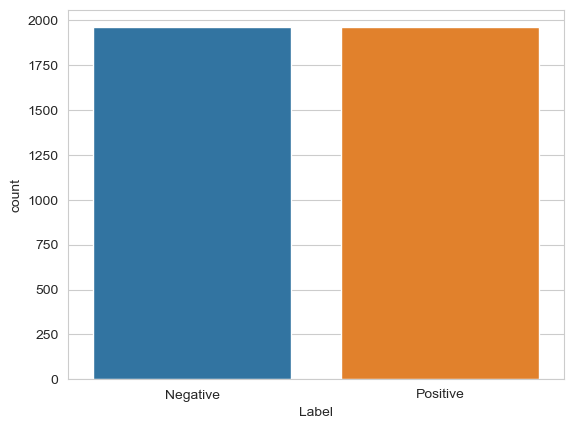

In [8]:
sns.set_style('whitegrid')
sns.countplot(x = 'Label', data = data)

In [9]:
# Remove the Text with least words
data['length'] = data['Cleaned'].apply(lambda x:len(x.split()))
dataset = data.loc[data.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Text".format(len(data)-len(dataset)),
      "\nTotal Text:",len(dataset))

After Cleaning: 
Removed 0 Small Text 
Total Text: 3920


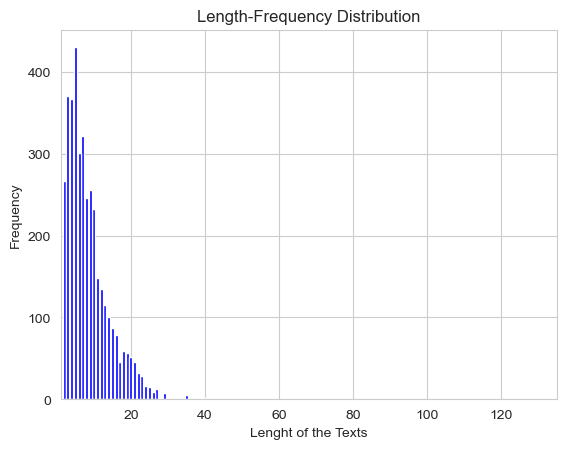

Maximum Length of a Text: 43
Minimum Length of a Text: 1
Average Length of a Text: 8.0


In [10]:
# Calculate the Text of each of the Text
dataset['TextLength'] = dataset.Cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.TextLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a Text: {max(dataset.TextLength)}")
print(f"Minimum Length of a Text: {min(dataset.TextLength)}")
print(f"Average Length of a Text: {round(np.mean(dataset.TextLength),0)}")

In [11]:
data.Cleaned

0       হেলো ম্যাডাম আমাদের কনো ধরনের ভ্যাকসিনের প্রয়ো...
1       হো গার ভিত্রে টাইগার বোম মলম লাগাইলে এমনে ভাবে...
2               হো গায় অতিরিক্ত কারেন্ট থাকলে যা হয় আরকি 
3                                   হেডার কারেন্ট কমে নাই
4                                            হেডার মহিলা 
                              ...                        
3915     অনেক সুন্দর মাশাল্লাহ হাহা রিয়েক্ট আর নেগেটিভ...
3916                          অনেক অনেক দোয়া রইল অফুরন্ত 
3917                       মোটামুটি ভালোই হয়েছে ভিডিওটা 
3918         বাংলাদেশ থেকে আপনার প্রতি অনেক অনেক ভালোবাসা
3919      তোমার ভিডিও গুলি আমার মন ভালো করার জন্য যথেষ্ট
Name: Cleaned, Length: 3920, dtype: object

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
import tensorflow.keras.backend as K

In [13]:
voc_size=10000
sent_length=max(dataset.TextLength)
num_of_epoch=15

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data.Cleaned, data.Label, test_size=0.2, random_state=42)
print('Train data:', X_train.shape[0])
print('Test data:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

Train data: 3136
Test data: 784


In [15]:
tokenizer = Tokenizer(num_words = voc_size, split = (' '))

tokenizer.fit_on_texts(X_train)

In [16]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [17]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    3136.000000
mean        8.909120
std         5.818606
min         1.000000
25%         5.000000
50%         7.000000
75%        12.000000
max        44.000000
Name: Cleaned, dtype: float64

In [18]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=sent_length)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=sent_length)

In [19]:
# Example of padded sequence
X_train_seq_trunc[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  335,  101,
        437,  273,  369,  100,    3,  404,   22, 1694,  477,  405])

In [20]:
le = LabelEncoder()

y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [21]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.2, random_state=42)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (628, 43)


In [22]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [23]:
model = models.Sequential()
model.add(layers.Embedding(voc_size, 8, input_length=sent_length))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 8)             80000     
                                                                 
 conv1d (Conv1D)             (None, 39, 128)           5248      
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 86,560
Trainable params: 86,560
Non-trainable params: 0
____________________________________________________

In [24]:
def deep_model(model, X_train, y_train, X_valid, y_valid):

    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy', precision, recall])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=num_of_epoch
                       , batch_size=64
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    return history

In [25]:
history = deep_model(model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)

Epoch 1/15
40/40 [==============================] - 3s 9ms/step - loss: 0.6850 - accuracy: 0.5905 - precision: 0.5999 - recall: 0.5401 - val_loss: 0.6572 - val_accuracy: 0.8567 - val_precision: 0.8966 - val_recall: 0.7451
Epoch 2/15
40/40 [==============================] - 0s 5ms/step - loss: 0.5628 - accuracy: 0.8545 - precision: 0.8962 - recall: 0.7906 - val_loss: 0.4516 - val_accuracy: 0.8726 - val_precision: 0.9181 - val_recall: 0.8188
Epoch 3/15
40/40 [==============================] - 0s 5ms/step - loss: 0.3064 - accuracy: 0.9246 - precision: 0.9527 - recall: 0.8887 - val_loss: 0.2632 - val_accuracy: 0.9108 - val_precision: 0.9366 - val_recall: 0.8535
Epoch 4/15
40/40 [==============================] - 0s 5ms/step - loss: 0.1481 - accuracy: 0.9597 - precision: 0.9747 - recall: 0.9335 - val_loss: 0.1872 - val_accuracy: 0.9299 - val_precision: 0.9493 - val_recall: 0.9018
Epoch 5/15
40/40 [==============================] - 0s 5ms/step - loss: 0.0789 - accuracy: 0.9753 - precision: 0

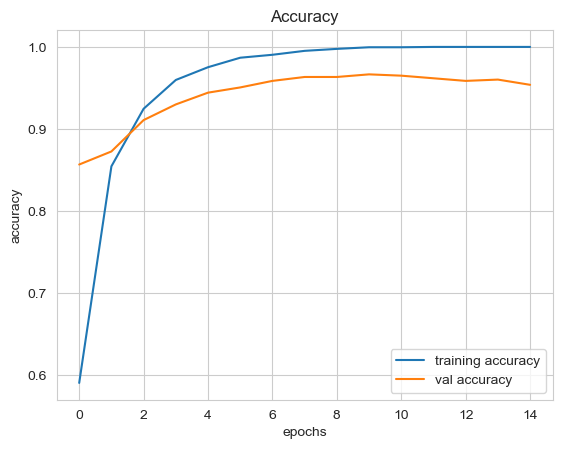

In [26]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

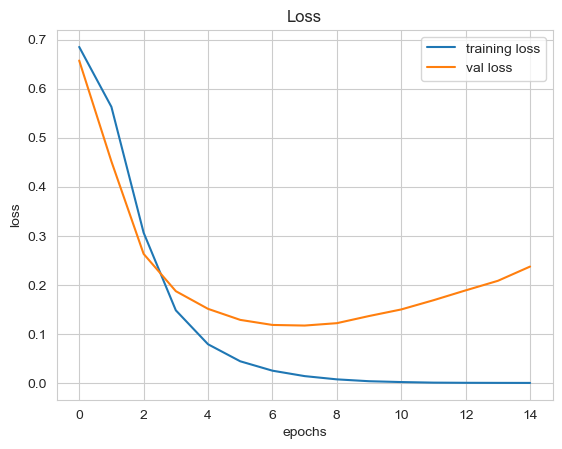

In [27]:
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [28]:
train_score = model.evaluate(X_train_seq_trunc, y_train_oh, verbose=0)
print('Train accuracy:', train_score[1])

Train accuracy: 0.9907525777816772


In [29]:
test_score = model.evaluate(X_test_seq_trunc, y_test_oh, verbose=0)
print('Test accuracy:', test_score[1])

Test accuracy: 0.9349489808082581


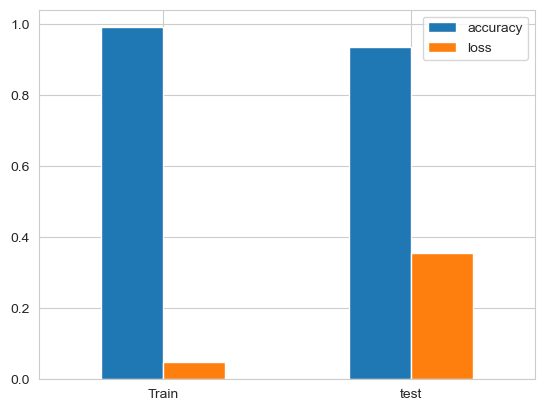

In [30]:
accuracy = [train_score[1], test_score[1]]
loss = [train_score[0], test_score[0]]
index = ['Train', 'test']
df = pd.DataFrame({'accuracy': accuracy,
                   'loss': loss}, index=index)
ax = df.plot.bar(rot=0)

In [31]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test_seq_trunc, y_test_oh, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))

def f1_score(precision, recall):
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9349
Precision : 0.9451
Recall    : 0.9300
F1 Score  : 0.9375


25/25 [==============================] - 0s 979us/step


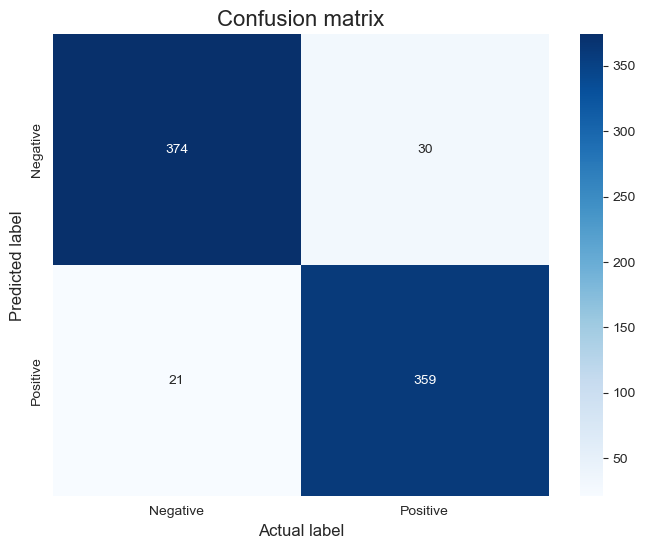

In [32]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):

    
    classes = ['Negative', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test_seq_trunc, y_test_oh)